## Global To Dos:
* read paper
* [steps document](https://docs.google.com/document/d/1du2fcmVzTqnW0FWGmUxvpR2t6QEfwxDIrHSZs9k3HZM/edit?usp=sharing)

Section 1: Load and Preprocess Data

In [41]:
import utils_preprocessing as up
import utils as ut
import importlib
importlib.reload(ut)
importlib.reload(up)
from itertools import groupby
import yaml
import os
import textdistance
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

## Pre-processing 

Read in YAML and make PATH

In [2]:
#with open("config.yml", 'r') as ymlfile:
#    cfg = yaml.load(ymlfile)

#PATH = os.path.join(cfg['data']['Directory'] + ":" + os.sep, cfg['data']['Folder1'], cfg['data']['Folder2'], cfg['data']['Folder3']) # Alix Path

PATH = 'SOTU/'
#PATH = '/Users/aleistermontfort/Desktop/speeches' # Aleister Path
filetype = '*txt'

Read in Data

In [4]:
speeches, numpar = up.reading_data(PATH,'*.txt')

Create Noun Phrases

In [6]:
new_speeches = up.chunks(speeches)

Clean Words

In [7]:
clean_speeches = up.clean_words(new_speeches)

Lemmatize Words

In [8]:
words_changed = up.word_changes(clean_speeches, 0.5, 100)

In [9]:
phrases_lemmed = up.lemmed_phrases(words_changed, clean_speeches)

Counting Occurrence of Terms

In [10]:
counted_words = up.count_words(phrases_lemmed)

Limit List to Top 1000

In [11]:
top_words = up.top_x(counted_words, 1000)

limit paragraph phrases only to those in top 1000

In [12]:
limited_paragraphs = up.limit(phrases_lemmed, top_words)

## Periodization

In [13]:
tfidfs = up.corpus_tfidf(limited_paragraphs, counted_words, top_words)

In [14]:
periods, dissimilarity = up.periodization(tfidfs)

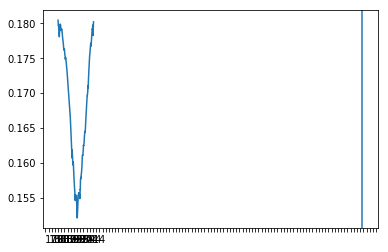

In [15]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.axvline(1914, 0,1)
plt.plot(x, y)
plt.show()

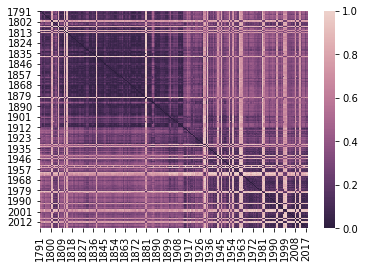

In [18]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
ax = sns.heatmap(dissimilarity, cmap=cmap)
plt.axvline((1914-pd.to_numeric(years[0])), 0,1)
plt.show()

### Before

Before Years

In [17]:
years = tfidfs.index
before_1914 = years[:(1914-pd.to_numeric(years[0]))]
before_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in before_1914}

Before TFIDF

In [19]:
before_tfidfs = up.corpus_tfidf(before_dict, counted_words, top_words)

In [20]:
before_periods, before_dissimilarity = up.periodization(before_tfidfs)

### After

After Years

In [21]:
after_1914 = years[(1914-pd.to_numeric(years[0])):]
after_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in after_1914}

After TFIDF

In [22]:
after_tfidfs = up.corpus_tfidf(after_dict, counted_words, top_words)

In [23]:
after_periods, after_dissimilarity = up.periodization(after_tfidfs)

In [24]:
new_periods = {**before_periods, **after_periods}

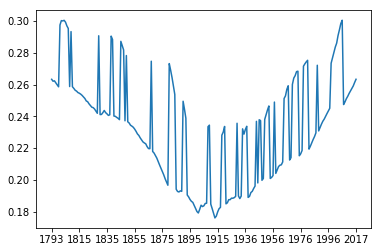

In [25]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(new_periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

plt.plot(x, y)
plt.show()

## Co-Occurrence Matrix and Dissimilarity Topic Modeling

Build the co-occurrence matrix

In [54]:
pre_occur = ut.convert_dict_to_list(limited_paragraphs)

In [55]:
co_occur = ut.co_oc_matrix(pre_occur, True, True)

Do a cosine similarity

In [56]:
co_matrix = ut.pairwise_similarity(co_occur, 'cosine')

Do a paper dissimilarity

In [43]:
co_matrix_paper = ut.pairwise_similarity(co_occur, 'paper')

### Global Corpus

Create network graph using community detection algorithms and paper's approach

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/layout.py:606: RuntimeWarning: invalid value encountered in less
  length = np.where(length < 0.01, 0.1, length)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/layout.py:598: RuntimeWarning: invalid value encountered in less
  distance = np.where(distance < 0.01, 0.01, distance)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


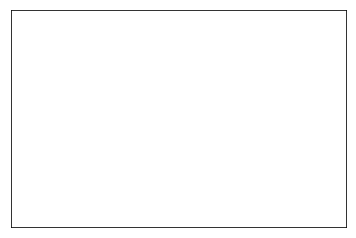

In [45]:
global_cda_paper = ut.network_graph(co_matrix_paper, 'community')

Create network graph using community detection algorithms and cosine similarity

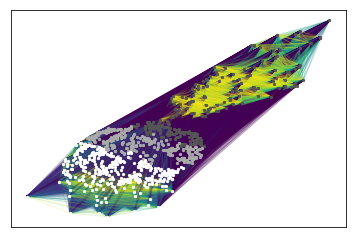

In [46]:
global_cda_cosine = ut.network_graph(co_matrix, 'community')

Create network graph using kmeans unsupervised clustering and paper's approach 

In [47]:
global_kmeans_paper = ut.network_graph(co_matrix_paper, 'kmeans')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Create network graph using kmeans unsupervised clustering and cosine similarity 

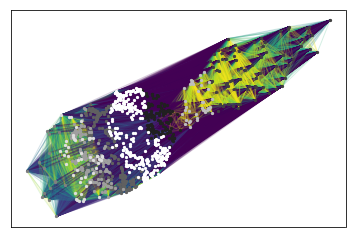

In [48]:
global_kmeans_cosine= ut.network_graph(co_matrix, 'kmeans')

### Before 1914 Corpus

First turn the before dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [58]:
before_occur = ut.convert_dict_to_list(before_dict)
co_before = ut.co_oc_matrix(before_occur, True, False)
before_cosine = ut.pairwise_similarity(co_before, 'cosine')
before_paper = ut.pairwise_similarity(co_before, 'paper')

Create network graph using community detection algorithm and paper dissimilarity

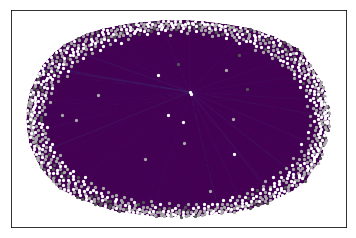

In [60]:
before_cda_paper = ut.network_graph(before_paper, 'community')

Create network graph using community detection algorithm and cosine dissimilarity

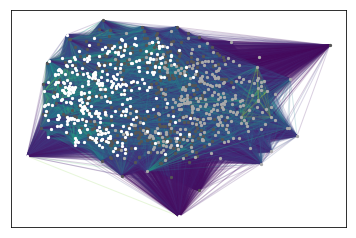

In [61]:
before_cda_cosine = ut.network_graph(before_cosine, 'community')

Create network graph using kmeans and paper dissimilarity

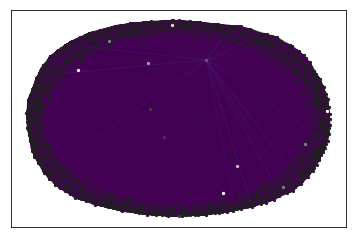

In [62]:
before_kmeans_paper = ut.network_graph(before_paper, 'kmeans')

Create network graph using kmeans and cosine similarity

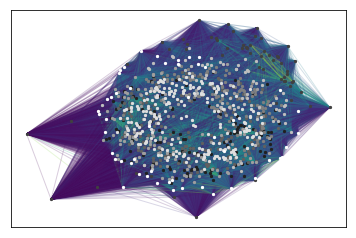

In [63]:
before_kmeans_cosine = ut.network_graph(before_cosine, 'kmeans')

### After 1914 Corpus

First turn the after dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [64]:
after_occur = ut.convert_dict_to_list(after_dict)
co_after = ut.co_oc_matrix(after_occur, True, False)
after_cosine = ut.pairwise_similarity(co_after, 'cosine')
after_paper = ut.pairwise_similarity(co_after, 'paper')

Create network graph using community detection algorithm and paper dissimilarity

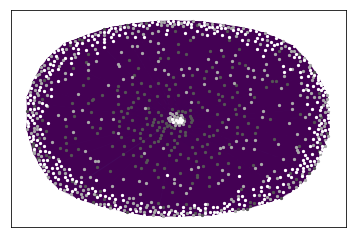

In [66]:
after_cda_paper = ut.network_graph(after_paper, 'community')

Create network graph using community detection algorithm and cosine dissimilarity

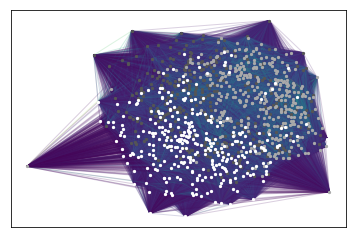

In [67]:
after_cda_cosine = ut.network_graph(after_cosine, 'community')

Create network graph using kmeans and paper dissimilarity

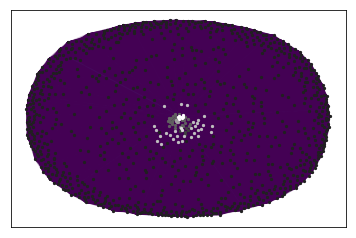

In [68]:
after_kmeans_paper = ut.network_graph(after_paper, 'kmeans')

Create network graph using kmeans and cosine similarity

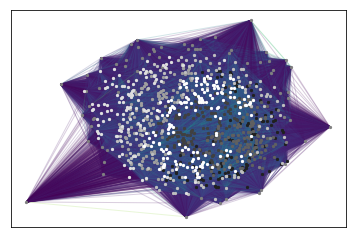

In [69]:
after_kmeans_cosine = ut.network_graph(after_cosine, 'kmeans')

## LDA Topic Modeling 